# Amazon Bedrock boto3 Setup

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

For more details refer to the [`Bedrock` Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [9]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"
%pip install "unstructured[csv]" "pillow>=9.5,<10" langchain==0.0.309 python-weather pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet

  Using cached boto3-1.42.12-py3-none-any.whl.metadata (6.8 kB)
  Using cached awscli-1.44.2-py3-none-any.whl.metadata (11 kB)
  Using cached botocore-1.42.12-py3-none-any.whl.metadata (5.9 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.16.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached docutils-0.19-py3-none-any.whl.metadata (2.7 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
Using cached boto3-1.42.12-py3-none-any.whl (140 kB)
Using cached botocore-1.42.

In [1]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Bedrock clients
This notebook demonstrates invoking Bedrock models directly using the AWS SDK

Here are links for some packages you might not be familiar with:

- [FAISS](https://github.com/facebookresearch/faiss), to store vector embeddings
- [sqlalchemy](https://www.sqlalchemy.org/), SQLAlchemy is the Python SQL toolkit 
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files
- [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/), for interactive UI widgets in the notebook
- [NeMo-Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) an open-source toolkit for easily adding programmable guardrails to LLM-based conversational systems


---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [2]:
import json
import os
import sys
import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from labutils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_PROFILE"] = ""
# os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Invoke Model

we will demonstrate the use of invoking the models and also highlight the default behaviour of LLM. They will return answer and data based on the training data. For our use case of AiStylist we need more curated responses. That means we will need to adopt a different architecture to get the model to execute our use case. Those techniques will be demonstrated in the next workbook

In [3]:
# If you'd like to try your own prompt, edit this parameter!
customer_input = "I am a male consultant in my 30s traveling to New York next week. What kind of outfit should I wear on my first day in the office? "

In [4]:
# first fetch possible styles and give options to customer
prompt = """

Human: list different style options for:
""" + customer_input + """

Assistant:"""
body = json.dumps({"anthropic_version": "bedrock-2023-05-31",
    "messages": [
        {"role": "user", "content": prompt}
    ],"max_tokens": 4096})
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"
claudeResponse = ""

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId
)
response_body = json.loads(response.get("body").read())
#styles_response = response_body.get("completion")
#print(styles_response)
response_text = response_body["content"][0]["text"]
print(response_text)

As a male consultant in your 30s visiting a New York office for the first time, it's generally advisable to dress in a professional and polished manner. Here are some style options to consider:

1. Classic Suit:
   - A well-fitted suit in a solid color like navy, charcoal gray, or dark gray is a safe and timeless choice.
   - Opt for a crisp, long-sleeved dress shirt in a neutral color like white or light blue.
   - Pair it with a conservative tie in a complementary color or pattern.
   - Leather dress shoes, such as oxfords or loafers, complete the look.

2. Blazer and Trousers:
   - A blazer in a solid color like navy or gray, paired with dress trousers in a matching or complementary shade.
   - A crisp dress shirt and a patterned or solid tie can be worn with this combination.
   - Leather dress shoes or dress boots are appropriate footwear options.

3. Sweater and Slacks:
   - A fine-gauge sweater in a solid color like navy, gray, or burgundy, worn over a dress shirt and tie.
   - 

## Generate the default images using stability.stable-diffusion-xl

Preparing received response to generate images for each style look

In [5]:
# Prepare input for fetching images for each of style
styles = [s.strip() for s in (list(filter(None, response_text.splitlines()))[1:-1])]
print(*styles, sep='\n')

1. Classic Suit:
- A well-fitted suit in a solid color like navy, charcoal gray, or dark gray is a safe and timeless choice.
- Opt for a crisp, long-sleeved dress shirt in a neutral color like white or light blue.
- Pair it with a conservative tie in a complementary color or pattern.
- Leather dress shoes, such as oxfords or loafers, complete the look.
2. Blazer and Trousers:
- A blazer in a solid color like navy or gray, paired with dress trousers in a matching or complementary shade.
- A crisp dress shirt and a patterned or solid tie can be worn with this combination.
- Leather dress shoes or dress boots are appropriate footwear options.
3. Sweater and Slacks:
- A fine-gauge sweater in a solid color like navy, gray, or burgundy, worn over a dress shirt and tie.
- Pair it with well-fitted dress slacks in a complementary color.
- Leather dress shoes or loafers work well with this outfit.
4. Khakis and a Dress Shirt:
- If the office environment is slightly more casual, you could conside

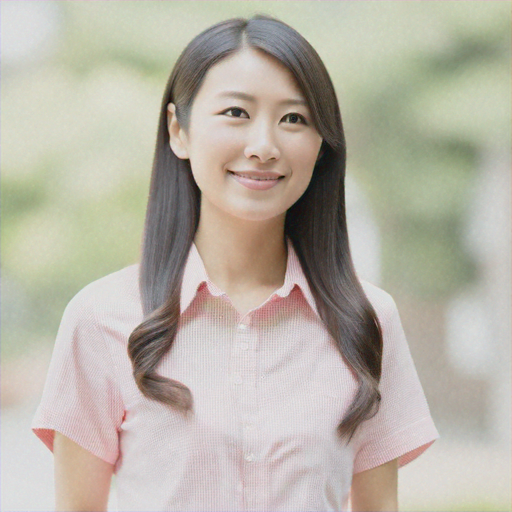

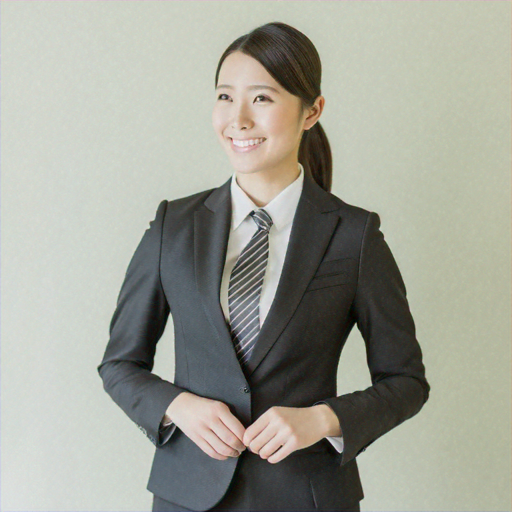

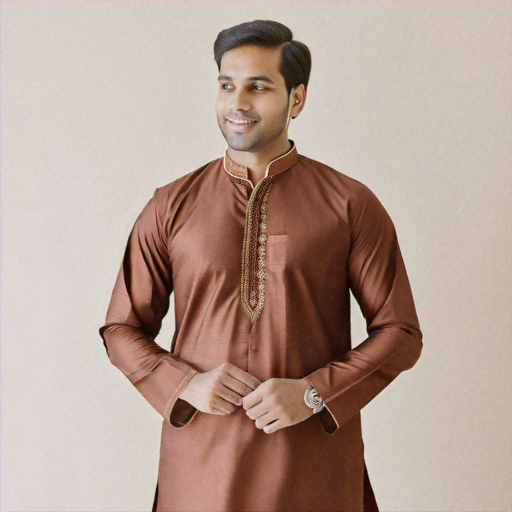

In [11]:
from PIL import Image
from IPython import display
from base64 import b64decode
import json
import os
import io
import boto3

# Initialize Bedrock Runtime
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1"
)

# Sample styles list (example)
styles = [
    "style-casual shirt",
    "style-formal suit",
    "style-traditional kurta"
]

# Create output folder
os.makedirs("data", exist_ok=True)

# Store images if needed
images = []

# Fetch images for each style
for i, style in enumerate(styles):

    if len(style.split("-")) > 1:
        prompt_text = "person wearing " + style.split("-")[1]

        # ---- Titan Image Generator payload ----
        request = json.dumps({
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": prompt_text
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 512,
                "width": 512,
                "cfgScale": 8,
                "seed": 5450
            }
        })

        # ---- Correct Titan model ID ----
        modelId = "amazon.titan-image-generator-v2:0"

        # Invoke Bedrock model
        response = bedrock_runtime.invoke_model(
            body=request,
            modelId=modelId,
            accept="application/json",
            contentType="application/json"
        )

        # Parse response
        response_body = json.loads(response["body"].read())

        # Extract Base64 image
        base64_img = response_body["images"][0]

        # Decode image
        image_bytes = b64decode(base64_img)
        image = Image.open(io.BytesIO(image_bytes))

        # Display image
        display.display(image)

        # Optional: save image
        image_path = f"data/image_{i}.png"
        image.save(image_path)

        images.append(image_path)
